In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

: 

Retomamos el filtro analógico de la semana pasada

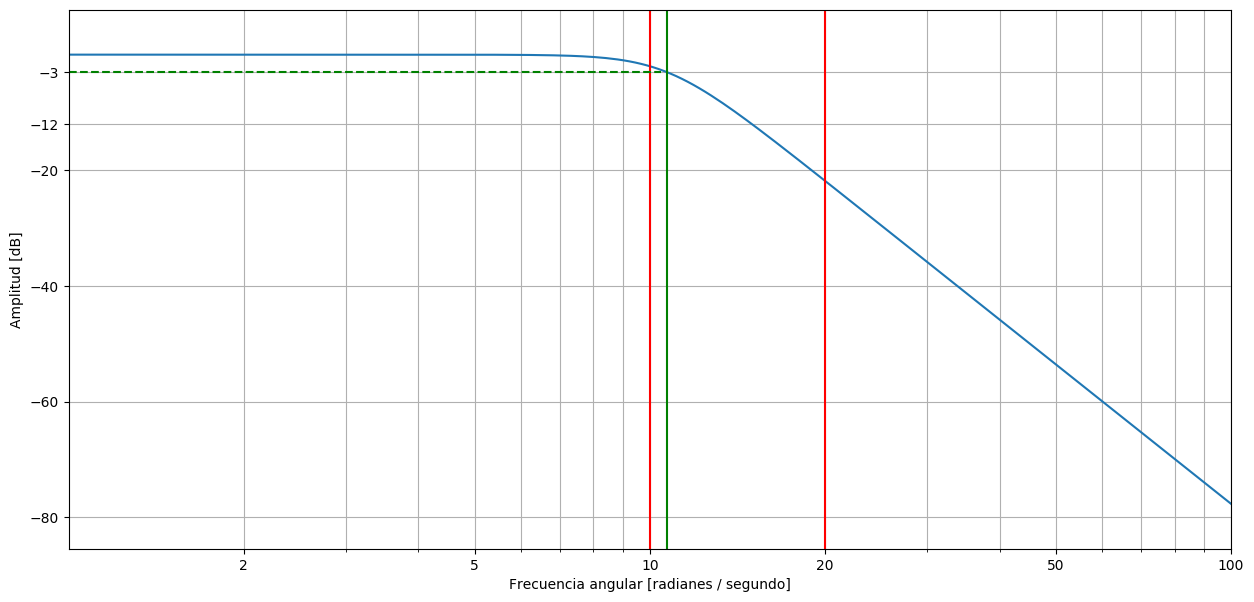

In [4]:
N=27 #orden del filtro analógico
Wc_1 = 10.09 #frecuencia de corte analógica
b_1, a_1 = signal.butter(4, Wc_1, 'low', analog=True) #diseño del filtro
w_1, h_1 = signal.freqs(b_1, a_1) #respuesta en frecuencia del filtro
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.semilogx(w_1, 20 * np.log10(abs(h_1)))
ax.set_xlabel('Frecuencia angular [radianes / segundo]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.axvline(Wc_1, color='green') #frecuencia de corte
ax.axvline(10,color='red') #final banda de paso
ax.axvline(20,color='red') #comienzo banda de atenuación
ax.axhline(-3,xmax=0.51, color='green',ls='--') # -3 dB
ax.set_xticks([2,5,10,20,50,100])
ax.set_yticks([-3,-12,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)

A partir de nuesto diseño analógico construimos un filtro digital mediante el método de la Transformada Bilineal.

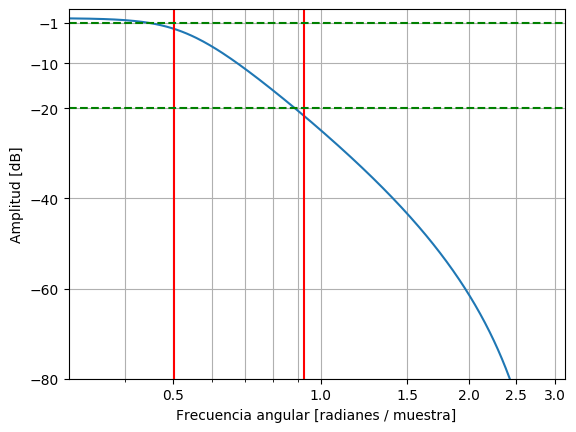

In [5]:
t_1 = 0.05 #periodo de muestreo
fs_1 = 1/t_1 #frecuencia de muestreo
b_digital, a_digital = signal.bilinear(b_1, a_1, fs_1) #mapeo de s a z con T. Bilineal
wz, hz = signal.freqz(b_digital, a_digital) #respuesta en frecuencia del filtro digital


fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(wz[50:], 20 * np.log10(abs(hz[50:])))
ax.set_xlabel('frecuencia angular [radianes / muestra]')
ax.set_ylabel('amplitud [db]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.set_ylim([-40,2])
wc_digital = 2 * np.arctan((wc*t_1)/2)
ax.axvline(0.16*np.pi,color='red') #final banda de paso
ax.axvline(0.295*np.pi,color='red') #comienzo banda de atenuación
ax.axhline(-1, color='green',ls='--') # -1 db
ax.axhline(-20, color='green',ls='--') # -20 dB
ax.set_xticks([0.5,1,1.5,2,2.5,3])
ax.set_yticks([-1,-10,-20,-40,-60,-80])
formatter = scalarformatter()
formatter.set_scientific(false)
ax.get_xaxis().set_major_formatter(formatter)


La diferencia que hay entre la ganancia teórica en la frecuencia final de la banda de paso y la que quedó se debe al redondeo que se hizo al principio del ejercicio cuando se transformaron las frecuencias analógicas a digitales.

## Analicemos otros métodos

## Invariancia al impulso

#### No está de forma nativa en SciPy, usamos un código hecho por una persona (gracias, Stack Overflow :) ).

In [6]:
# -*- coding: utf-8 -*-
"""
Python transcript of Octave impinvar function for application of impulse invariance
Note that this module is covered by the GPLv3 license.
"""

import numpy as np
import scipy.signal as dsp
from math import factorial
from scipy.special import binom

polyrev = lambda p_in: p_in[::-1]

def prepad(vec, length, value=0):
	if length > len(vec):
		return np.r_[value * np.ones(length - len(vec)), vec]
	elif length < len(vec):
		return vec[-length:]
	else:
		return vec

def h1_z_deriv(n, p, ts):
	"""
	## Copyright (C) 2007 R.G.H. Eschauzier <reschauzier@yahoo.com>
	## Copyright (C) 2016 S. Eichstädt <sascha.eichstaedt@ptb.de>
	##
	## This program is free software; you can redistribute it and/or modify it under
	## the terms of the GNU General Public License as published by the Free Software
	## Foundation; either version 3 of the License, or (at your option) any later
	## version.
	##
	## This program is distributed in the hope that it will be useful, but WITHOUT
	## ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
	## FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
	## details.
	##
	## You should have received a copy of the GNU General Public License along with
	## this program; if not, see <http://www.gnu.org/licenses/>.
	## -*- texinfo -*-
	## @deftypefn {Function File} {@var{b} =} h1_z_deriv (@var{n}, @var{p}, @var{ts})
	## Undocumented internal function.  This function is used by the impinvar
	## and invimpinvar functions in the signal package.
	## @end deftypefn
	## Adapted by Carnë Draug on 2011 <carandraug+dev@gmail.com>
	## Find {-zd/dz}^n*H1(z). I.e., first differentiate, then multiply by -z, then differentiate, etc.
	## The result is (ts^(n+1))*(b(1)*p/(z-p)^1 + b(2)*p^2/(z-p)^2 + b(n+1)*p^(n+1)/(z-p)^(n+1)).
	## Works for n>0.
	"""
	# Build the vector d that holds coefficients for all the derivatives of H1(z)
	## The results reads d(n)*z^(1)*(d/dz)^(1)*H1(z) + d(n-1)*z^(2)*(d/dz)^(2)*H1(z) +...+ d(1)*z^(n)*(d/dz)^(n)*H1(z)

	d = [(-1)**n] # Vector with the derivatives of H1(z)
	for i in range(n-1):
		d  = [d, 0]                     # Shift result right (multiply by -z)
		d += prepad(np.polyder(d), i + 1, 0) # Add the derivative

	## Build output vector
	b = np.zeros(n + 1)
	for i in range(n):
		b += d[i] * prepad(h1_deriv(n-i+1), n+1, 0)

	b *= ts**(n+1)/factorial(n)

	## Multiply coefficients with p^i, where i is the index of the coeff.
	b *=p**(np.arange(n+1,0,-1))

	return b



def h1_deriv(n):
	"""
	Find (z^n)*(d/dz)^n*H1(z), where H1(z)=ts*z/(z-p), ts=sampling period,
	p=exp(sm*ts) and sm is the s-domain pole with multiplicity n+1.
	The result is (ts^(n+1))*(b(1)*p/(z-p)^1 + b(2)*p^2/(z-p)^2 + b(n+1)*p^(n+1)/(z-p)^(n+1)),
	where b(i) is the binomial coefficient bincoeff(n,i) times n!. Works for n>0.
	"""
	bincoeffs = np.zeros(n+1)
	for k in range(n+1):
		bincoeffs[k] = binom(n, k)
	b  = factorial(n)*bincoeffs # Binomial coefficients: [1], [1 1], [1 2 1], [1 3 3 1], etc.
	b *= (-1)**n
	return b



def z_res(r_in, sm, ts):
	p_out = np.exp(ts * sm)  # z-domain pole
	n = len(r_in)  # Multiplicity of the pole
	r_out = np.zeros(n, dtype = complex)  # Residue vector

	## First pole (no multiplicity)
	k_out = to_real(r_in[0] * ts)  # PFE of z/(z-p) = p/(z-p)+1; direct part
	r_out[0] = r_in[0] * ts * p_out  # pole part of PFE

	for i in range(1, n):  # Go through s-domain residues for multiple pole
		r_out[:i] += r_in[i] * polyrev(h1_z_deriv(i, p_out, ts))  # Add z-domain residues

	return r_out, p_out, k_out

def to_real(p_in):
	## Copyright (C) 2007 R.G.H. Eschauzier <reschauzier@yahoo.com>
	## Copyright (C) 2016 S. Eichstädt <sascha.eichstaedt@ptb.de>
	##
	## This program is free software; you can redistribute it and/or modify it under
	## the terms of the GNU General Public License as published by the Free Software
	## Foundation; either version 3 of the License, or (at your option) any later
	## version.
	##
	## This program is distributed in the hope that it will be useful, but WITHOUT
	## ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
	## FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
	## details.
	##
	## You should have received a copy of the GNU General Public License along with
	## this program; if not, see <http://www.gnu.org/licenses/>.

	## -*- texinfo -*-
	## @deftypefn {Function File} {@var{p_out} =} to_real (@var{p_in})
	## Undocumented internal function.  This function is used by the impinvar
	## and invimpinvar functions in the signal package.
	## @end deftypefn

	## Adapted by Carnë Draug on 2011 <carandraug+dev@gmail.com>

	## Round complex number to nearest real number

	return np.abs(p_in)*np.sign(np.real(p_in))



def impinvar(b_in, a_in, fs = 1, tol = 0.0001):
	"""
	## Copyright (c) 2007 R.G.H. Eschauzier <reschauzier@yahoo.com>
	## Copyright (c) 2011 Carnë Draug <carandraug+dev@gmail.com>
	## Copyright (c) 2011 Juan Pablo Carbajal <carbajal@ifi.uzh.ch>
	## Copyright (c) 2016 Sascha Eichstaedt <sascha.eichstaedt@ptb.de>
	##
	## This program is free software; you can redistribute it and/or modify it under
	## the terms of the GNU General Public License as published by the Free Software
	## Foundation; either version 3 of the License, or (at your option) any later
	## version.
	##
	## This program is distributed in the hope that it will be useful, but WITHOUT
	## ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
	## FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
	## details.
	##
	## You should have received a copy of the GNU General Public License along with
	## this program; if not, see <http://www.gnu.org/licenses/>.
	"""

	ts = 1 / fs  # we should be using sampling frequencies to be compatible with Matlab

	[r_in, p_in, k_in] = dsp.residue(b_in, a_in)  # partial fraction expansion

	n = len(r_in)  # Number of poles/residues

	if (len(k_in) > 0):  # Greater than zero means we cannot do impulse invariance
		if abs(k_in)>0:
			raise ValueError("Order numerator >= order denominator")

	r_out = np.zeros(n, dtype = complex)  # Residues of H(z)
	p_out = np.zeros(n, dtype = complex)  # Poles of H(z)
	k_out = np.zeros(1)  # Constant term of H(z)

	i = 0
	while (i < n):
		m = 0
		first_pole = p_in[i]  # Pole in the s-domain
		while (i < (n-1) and np.abs(first_pole - p_in[i + 1]) < tol):  # Multiple poles at p(i)
			i += 1 # Next residue
			m += 1  # Next multiplicity
		[r, p, k] = z_res(r_in[i - m:i+1], first_pole, ts) # Find z-domain residues
		k_out += k  # Add direct term to output
		p_out[i - m:i+1]   = p  # Copy z-domain pole(s) to output
		r_out[i - m:i+1]   = r  # Copy z-domain residue(s) to output

		i += 1  # Next s-domain residue/pole

	[b_out, a_out] = dsp.invres(r_out, p_out, k_out, tol=tol)
	a_out = to_real(a_out)  # Get rid of spurious imaginary part
	b_out = to_real(b_out)

	## Shift results right to account for calculating in z instead of z^-1
	b_out = b_out[:-1]

	return b_out, a_out

def impinvar_causal(*args, **kwargs):
	"""causal version of impinvar, h[0] == 0"""

	# polynomial.polysub is ordered from lowest to highest
	from numpy.polynomial.polynomial import polysub

	bz, az = impinvar(*args, **kwargs)

	h0 = bz[0] / az[0]
	bz = polysub(bz, h0 * az)
	return bz, az

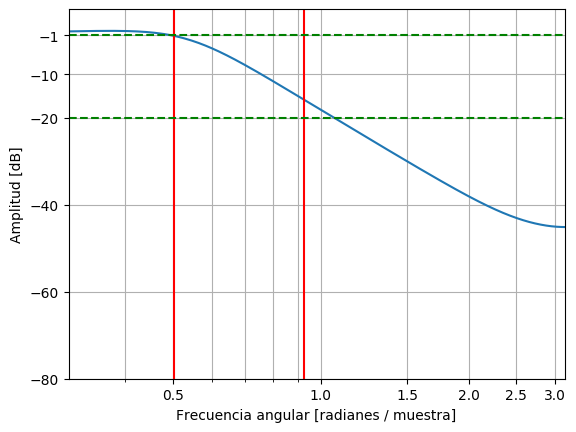

In [7]:
b_inv,a_inv = impinvar_causal(b_1,a_1,fs=fs_1)
wz_inv, hz_inv = signal.freqz(b_inv, a_inv) #respuesta en frecuencia del filtro digital
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(wz_inv[50:], 20 * np.log10(abs(hz_inv[50:]/np.max(np.abs(hz_inv)))))
ax.set_xlabel('Frecuencia angular [radianes / muestra]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.set_ylim([-40,5])
wc_digital = 2 * np.arctan((Wc*T_1)/2)
ax.axvline(0.16*np.pi,color='red') #final banda de paso
ax.axvline(0.295*np.pi,color='red') #comienzo banda de atenuación
ax.axhline(-1, color='green',ls='--') # -1 dB
ax.axhline(-20, color='green',ls='--') # -20 dB
ax.set_xticks([0.5,1,1.5,2,2.5,3])
ax.set_yticks([-1,-10,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)


Comparemos los gráficos de los dos métodos


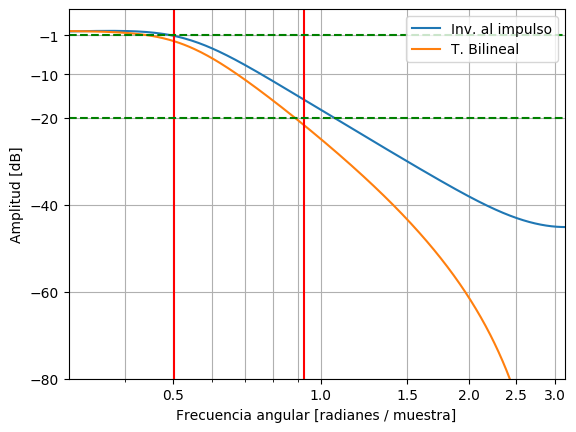

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(wz_inv[50:], 20 * np.log10(abs(hz_inv[50:])/np.max(np.abs(hz_inv))),label='Inv. al impulso')
ax.semilogx(wz[50:], 20 * np.log10(abs(hz[50:])),label='T. Bilineal')
ax.set_xlabel('Frecuencia angular [radianes / muestra]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.set_ylim([-40,5])
wc_digital = 2 * np.arctan((Wc*T_1)/2)
ax.axvline(0.16*np.pi,color='red') #final banda de paso
ax.axvline(0.295*np.pi,color='red') #comienzo banda de atenuación
ax.axhline(-1, color='green',ls='--') # -1 dB
ax.axhline(-20, color='green',ls='--') # -20 dB
ax.set_xticks([0.5,1,1.5,2,2.5,3])
ax.set_yticks([-1,-10,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)
ax.legend()

## Probemos otro período de muestreo



Con T = 1, las frecuencias analógicas quedan:
$$\Omega_p = 0,5135$$
$$\Omega_s = 0,999$$
$$\Omega_c = 0,54$$

Rediseñamos el filtro analógico con este cambio

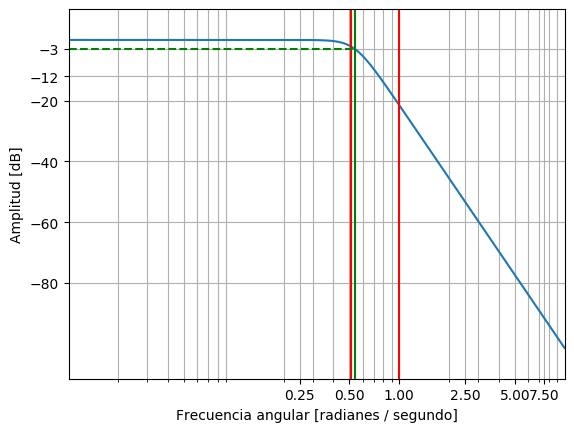

In [10]:
N=4 #orden del filtro analógico
Wc = 0.54 #frecuencia de corte analógica
b_2, a_2 = signal.butter(N, Wc, 'low', analog=True) #diseño del filtro
w_2, h_2 = signal.freqs(b_2, a_2) #respuesta en frecuencia del filtro
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(w_2, 20 * np.log10(abs(h_2)))
ax.set_xlabel('Frecuencia angular [radianes / segundo]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.axvline(Wc, color='green') #frecuencia de corte
ax.axvline(0.5135,color='red') #final banda de paso
ax.axvline(0.999,color='red') #comienzo banda de atenuación
ax.axhline(-3,xmax=0.575, color='green',ls='--') # -3 dB
ax.set_xticks([0.25,0.5,1,2.5,5,7.5])
ax.set_yticks([-3,-12,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)

Pasamos a digital con T. Bilineal

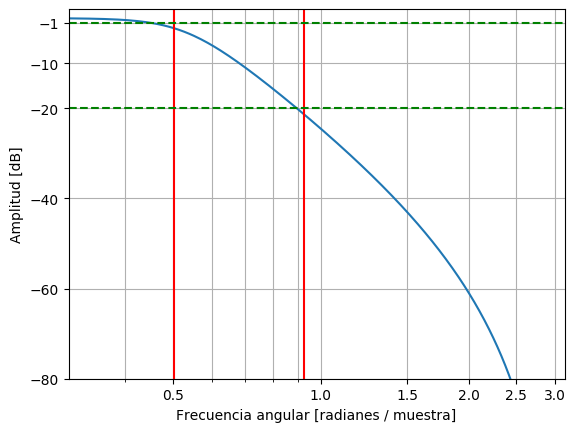

In [11]:
T_2 = 1 #periodo de muestreo
fs_2 = 1/T_2 #frecuencia de muestreo
b_digital2, a_digital2 = signal.bilinear(b_2, a_2, fs_2) #mapeo de s a z con T. Bilineal
wz2, hz2 = signal.freqz(b_digital2, a_digital2) #respuesta en frecuencia del filtro digital
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(wz2[50:], 20 * np.log10(abs(hz2[50:])))
ax.set_xlabel('Frecuencia angular [radianes / muestra]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.set_ylim([-40,2])
wc_digital = 2 * np.arctan((Wc*T_2)/2)
ax.axvline(0.16*np.pi,color='red') #final banda de paso
ax.axvline(0.295*np.pi,color='red') #comienzo banda de atenuación
ax.axhline(-1, color='green',ls='--') # -1 dB
ax.axhline(-20, color='green',ls='--') # -20 dB
ax.set_xticks([0.5,1,1.5,2,2.5,3])
ax.set_yticks([-1,-10,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)

Comparemos con el primer diseño hecho con $T=0.05$




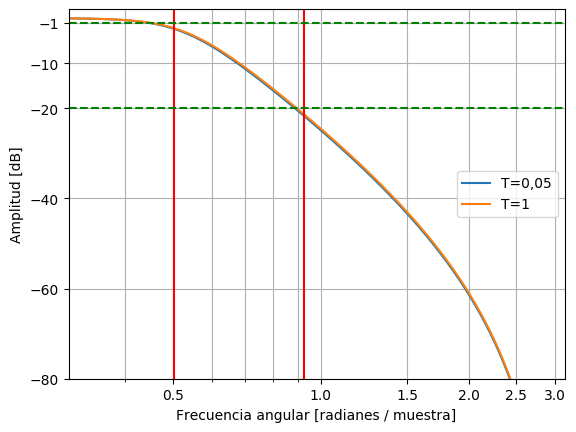

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(wz[50:], 20 * np.log10(abs(hz[50:])),label='T=0,05')
ax.semilogx(wz2[50:], 20 * np.log10(abs(hz2[50:])),label='T=1')
ax.set_xlabel('Frecuencia angular [radianes / muestra]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.set_ylim([-40,2])
#wc_digital = 2 * np.arctan((Wc*T_1)/2)
ax.axvline(0.16*np.pi,color='red') #final banda de paso
ax.axvline(0.295*np.pi,color='red') #comienzo banda de atenuación
ax.axhline(-1, color='green',ls='--') # -1 dB
ax.axhline(-20, color='green',ls='--') # -20 dB
ax.set_xticks([0.5,1,1.5,2,2.5,3])
ax.set_yticks([-1,-10,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)
ax.legend()

Queda comprobado que en este tipo de ejercicios en el que se hace pre-warping (pasaje de frecuencias digitales a analógicas) el período de muestreo $T$ no afecta.

## ¿Cómo hago un pasa altos?

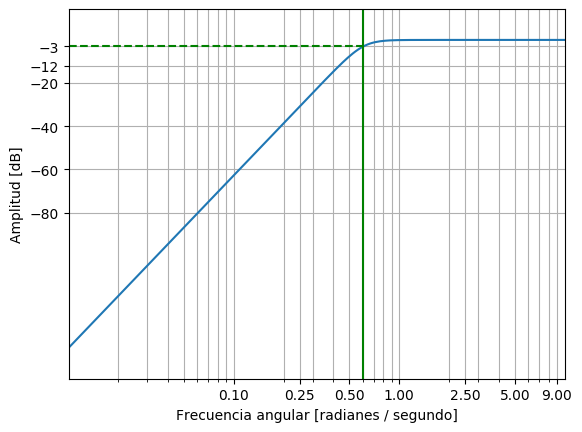

In [13]:
N=4 #orden del filtro analógico
Wc = 0.607 #frecuencia de corte analógica
b_h, a_h = signal.butter(N, Wc, 'high', analog=True) #diseño del filtro
w_h, h_h = signal.freqs(b_h, a_h) #respuesta en frecuencia del filtro
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(w_h, 20 * np.log10(abs(h_h)))
ax.set_xlabel('Frecuencia angular [radianes / segundo]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.axvline(Wc, color='green') #frecuencia de corte
ax.axhline(-3,xmax=0.6, color='green',ls='--') # -3 dB
ax.set_xticks([0.1,0.25,0.5,1,2.5,5,9])
ax.set_yticks([-3,-12,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)


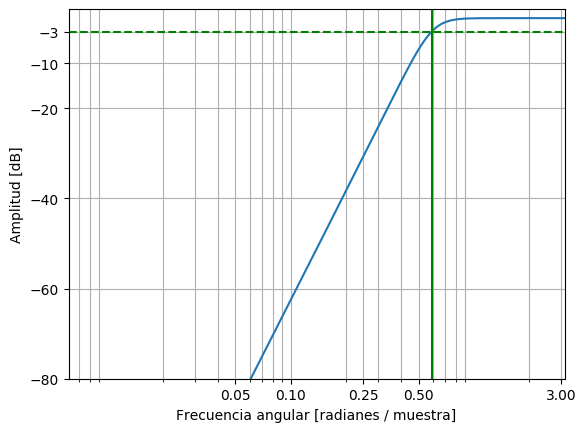

In [14]:
T = 1 #periodo de muestreo
fs = 1/T #frecuencia de muestreo
b_digital_h, a_digital_h = signal.bilinear(b_h, a_h, fs) #mapeo de s a z con T. Bilineal
wz_h, hz_h = signal.freqz(b_digital_h, a_digital_h) #respuesta en frecuencia del filtro digital
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(wz_h, 20 * np.log10(abs(hz_h)))
ax.set_xlabel('Frecuencia angular [radianes / muestra]')
ax.set_ylabel('Amplitud [dB]')
ax.margins(0, 0.1)
ax.grid(which='both', axis='both')
ax.set_ylim([-40,2])
wc_digital = 2 * np.arctan((Wc*T)/2)
ax.axvline(wc_digital,color='green') #frecuencia de corte
ax.axhline(-3, color='green',ls='--') # -3 dB
ax.set_xticks([0.05,0.1,0.5,0.25,3])
ax.set_yticks([-3,-10,-20,-40,-60,-80])
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.get_xaxis().set_major_formatter(formatter)